## Step 1. Load packages

In [36]:
import scanpy as sc
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import pandas as pd
import numpy as np
import json
import cv2
from scipy.ndimage import rotate, zoom
from scipy.ndimage import gaussian_filter
from skimage.metrics import structural_similarity as ssim
from app import * 

## Step 2. Pepare Visium

In [2]:
def otsu_filter(adata, tissue_dir):
    import cv2
    img = cv2.imread(tissue_dir + '/spatial/tissue_hires_image.png')

    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    blurred = cv2.GaussianBlur(gray_img, (5, 5), 0)

    ret, otsu_thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    threshold_offset = 5  # This can be adjusted as needed
    new_thresh = ret + threshold_offset
    _, adjusted_otsu_thresh = cv2.threshold(blurred, new_thresh, 255, cv2.THRESH_BINARY)
    
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(gray_img, cmap='gray')
    plt.title('Grayscale Image')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(otsu_thresh, cmap='gray')
    plt.title('Original Otsu Thresholding')
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(adjusted_otsu_thresh, cmap='gray')
    plt.title('Adjusted Otsu Thresholding')
    plt.axis('off')
    plt.show()

    br_coord = pd.read_csv(tissue_dir + '/spatial/tissue_positions_list.csv',
                        header=None, names= ['barcodes','tissue','row','col','imgrow','imgcol'])

    json_file_path = tissue_dir + '/spatial/scalefactors_json.json'
    with open(json_file_path, 'r') as file:
        data = json.load(file)
    tissue_hires_scalef = data.get('tissue_hires_scalef')

    adata.obs['in_tissue'] = 1
    for i in range(adata.shape[0]):
        index = adata.obs.index[i]
        rr = br_coord[br_coord['barcodes'] == index]['imgrow'].values[0] * tissue_hires_scalef
        rr = int(rr)
        cc = br_coord[br_coord['barcodes'] == index]['imgcol'].values[0] * tissue_hires_scalef
        cc = int(cc)
    
        if adjusted_otsu_thresh[rr, cc] == 255:
            adata.obs['in_tissue'][i] = 0

    adata_ = adata[adata.obs['in_tissue'] == 1, ]
    return adata_

/home/jeongbinpark/miniconda3/envs/SuperST/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


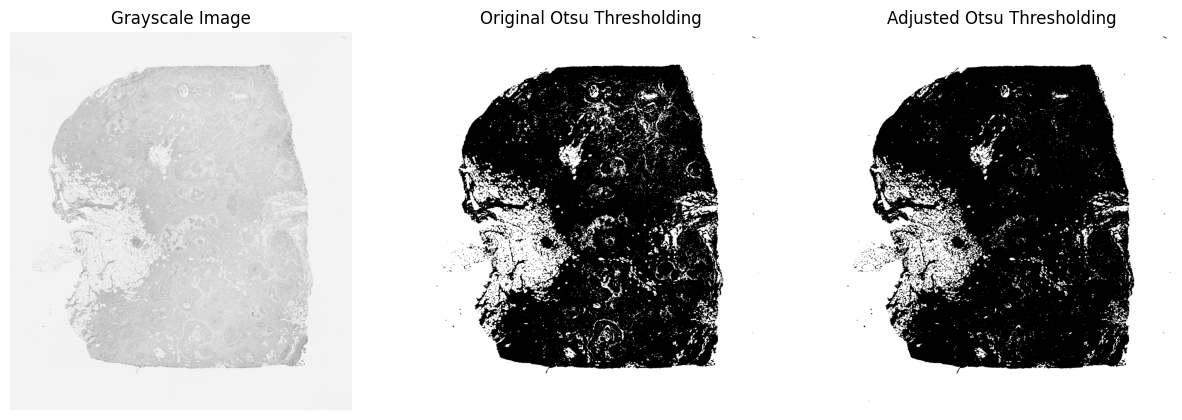

In [3]:
tissue_dir = './visium_xenium_human_breast_cancer/visium/'
visium = sc.read_visium(tissue_dir)
visium = otsu_filter(visium, tissue_dir)

/home/jeongbinpark/miniconda3/envs/SuperST/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


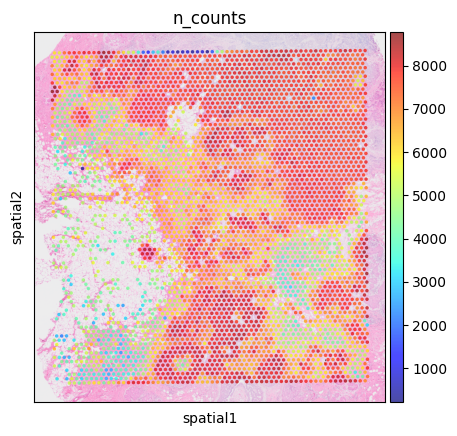

In [4]:
visium.var_names_make_unique() 
sc.pp.normalize_total(visium, inplace=True) 
sc.pp.log1p(visium)
visium.obs['n_counts'] = visium.X.sum(axis=1).A1
sc.pl.spatial(visium, img_key="hires", color='n_counts', alpha=0.7, cmap='jet')

## Step 3. Prepare Xenium

In [5]:
xenium = sc.read_h5ad('./human_breast_xenium.h5ad')

## Step 4. Visualize ERBB2

In [6]:
gene_list = xenium.var.index.intersection(visium.var.index)
print(len(gene_list))

307


In [18]:
iter = 512
demask_image_t, demask_image_t_g, tsimg1_, conv_spatial_images_ = \
         merge(tissue_dir, gene_list, num_iter = iter, is_cut_bg = True)

/home/jeongbinpark/miniconda3/envs/SuperST/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


{'regist_target_img_scalef': 0.2781512, 'tissue_hires_scalef': 0.092717074, 'tissue_lowres_scalef': 0.027815122, 'fiducial_diameter_fullres': 191.75371240966362, 'spot_diameter_fullres': 127.8358082731091}


/home/jeongbinpark/_superst/_imagizer_mask.py:63: FutureWarning: `draw.circle` is deprecated in favor of `draw.disk`.`draw.circle` will be removed in version 0.19
  r, c = draw.circle(rr, cc, radius = radius)


number of features: 307
...1/307
...101/307
...201/307
...301/307
number of features: 307
...1/307
...101/307
...201/307
...301/307
number of features: 307
...1/307
...101/307
...201/307
...301/307


In [19]:
def process_image(img, angle, scale, left_margin, right_margin, top_margin, bottom_margin):
    """
    Processes the input image by performing the following steps:
    
    1. Rotates the image by a specified angle.
    2. Scales the image according to the given scale factor.
    3. Crops the image by removing specified margins from all sides.

    Parameters:
    img : ndarray
        The input image, can be grayscale or RGB.
    angle : float
        The angle in degrees by which to rotate the image.
    scale : float
        The factor by which to scale the image (zoom in or out).
    left_margin : int
        The number of pixels to crop from the left side of the image.
    right_margin : int
        The number of pixels to crop from the right side of the image.
    top_margin : int
        The number of pixels to crop from the top of the image.
    bottom_margin : int
        The number of pixels to crop from the bottom of the image.

    Returns:
    cropped_img : ndarray
        The processed image after rotation, scaling, and cropping.
    """
    
    rotated_img = rotate(img, angle, reshape=True, mode='nearest')
    
    if rotated_img.ndim == 2:  
        zoom_factors = (scale, scale)  
    else:  # RGB image
        zoom_factors = (scale, scale, 1)  

    scaled_img = zoom(rotated_img, zoom_factors, order=1)  # Apply zoom with corrected factors

    start_row = top_margin
    end_row = scaled_img.shape[0] - bottom_margin
    start_col = left_margin
    end_col = scaled_img.shape[1] - right_margin

    cropped_img = scaled_img[start_row:end_row, start_col:end_col]    
    return cropped_img

def rgb_to_grayscale(img):
    """
    Converts an RGB image to grayscale. If the image is already in grayscale 
    (i.e., a 2D array), it returns the image as is. Otherwise, it converts 
    the RGB image to grayscale using a weighted sum of the red, green, 
    and blue channels.

    Parameters:
    img : ndarray
        The input image, either a 2D grayscale image or a 3D RGB image.

    Returns:
    ndarray:
        The grayscale version of the input image. If the input is already grayscale,
        the original image is returned.
    """
    if img.ndim == 2:  
        return img
    else:  
        return np.dot(img[..., :3], [0.2989, 0.5870, 0.1140])


def xenium_to_superst_space(xenium, gene, tsimg1_):
    """
    Maps the gene expression values of a specific gene from Xenium data onto the spatial coordinates 
    of the SuperST image, allowing for visual comparison between Xenium and SuperST data.

    Parameters:
    xenium : AnnData
        An AnnData object containing Xenium data with gene expression values and spatial coordinates.
    gene : str
        The name of the gene whose expression values are to be mapped.
    tsimg1_ : ndarray
        The SuperST image on which the gene expression values will be mapped. This is used to define 
        the output space dimensions.

    Returns:
    gene_expression_img : ndarray
        A 2D image with the same spatial dimensions as the SuperST image, where the intensity of each 
        pixel corresponds to the gene expression level at that location.
    """

    tsimg1_shape = tsimg1_.shape[:2]
    
    gene_expression_img = np.zeros(tsimg1_shape)
    
    gene_index = xenium.var.index.get_loc(gene)  
    gene_expression = xenium.X[:, gene_index].toarray().flatten() 
    
    x_norm = (xenium.obs['x_centroid'] - xenium.obs['x_centroid'].min()) / \
             (xenium.obs['x_centroid'].max() - xenium.obs['x_centroid'].min())
    y_norm = (xenium.obs['y_centroid'] - xenium.obs['y_centroid'].min()) / \
             (xenium.obs['y_centroid'].max() - xenium.obs['y_centroid'].min())
    
    x_coords = np.round(x_norm * (tsimg1_shape[1] - 1)).astype(int)
    y_coords = np.round(y_norm * (tsimg1_shape[0] - 1)).astype(int)
    
    x_coords = np.clip(x_coords, 0, tsimg1_shape[1] - 1)
    y_coords = np.clip(y_coords, 0, tsimg1_shape[0] - 1)
    
    for i in range(len(gene_expression)):
        gene_expression_img[y_coords[i], x_coords[i]] += gene_expression[i] 
    
    return gene_expression_img


def tesla_to_superst_space(tesla, gene, tsimg1_):
    """
    Maps the gene expression values from the Tesla data onto the SuperST image space using bilinear interpolation.
    This function ensures that the gene expression values are smoothly distributed across neighboring pixels in the 
    SuperST image, minimizing grid-like artifacts.

    Parameters:
    tesla : AnnData
        An AnnData object containing Tesla data with gene expression values and spatial coordinates.
    gene : str
        The name of the gene whose expression values are to be mapped.
    tsimg1_ : ndarray
        The SuperST image on which the gene expression values will be mapped. This is used to define 
        the output space dimensions.

    Returns:
    gene_expression_img : ndarray
        A 2D image with the same spatial dimensions as the SuperST image, where the intensity of each 
        pixel corresponds to the gene expression level at that location, with values distributed using bilinear interpolation.
    """
    tsimg1_shape = tsimg1_.shape[:2]
    
    gene_expression_img = np.zeros(tsimg1_shape)
    
    gene_index = tesla.var.index.get_loc(gene)  
    gene_expression = tesla.X[:, gene_index].flatten() 
    
    x_norm = (tesla.obs['x'] - tesla.obs['x'].min()) / \
             (tesla.obs['x'].max() - tesla.obs['x'].min())
    y_norm = (tesla.obs['y'] - tesla.obs['y'].min()) / \
             (tesla.obs['y'].max() - tesla.obs['y'].min())
    
    x_coords_float = x_norm * (tsimg1_shape[1] - 1)
    y_coords_float = y_norm * (tsimg1_shape[0] - 1)
    
    for i in range(len(gene_expression)):
        x = x_coords_float[i]
        y = y_coords_float[i]
        
        x0, x1 = int(np.floor(x)), int(np.ceil(x))
        y0, y1 = int(np.floor(y)), int(np.ceil(y))
        
        wx1, wx0 = x - x0, x1 - x
        wy1, wy0 = y - y0, y1 - y
        
        x0, x1 = np.clip([x0, x1], 0, tsimg1_shape[1] - 1)
        y0, y1 = np.clip([y0, y1], 0, tsimg1_shape[0] - 1)
        
        gene_expression_img[y0, x0] += gene_expression[i] * wx0 * wy0
        gene_expression_img[y0, x1] += gene_expression[i] * wx1 * wy0
        gene_expression_img[y1, x0] += gene_expression[i] * wx0 * wy1
        gene_expression_img[y1, x1] += gene_expression[i] * wx1 * wy1
    
    return gene_expression_img

In [21]:
# Define margins (hyperparameters)
theta = 88
size = 1.9
left_margin = 104
right_margin = 92
top_margin = 127
bottom_margin = 151

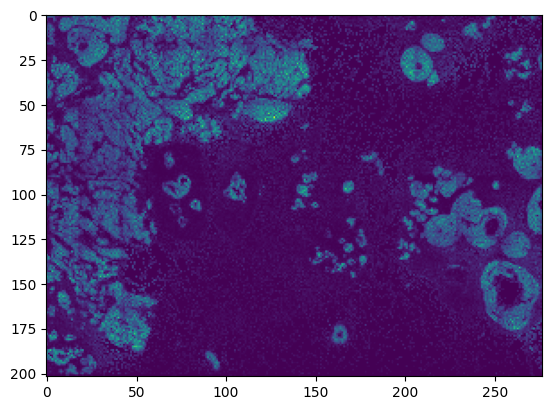

In [22]:
## Xenium
def xenium_gene(gene):
    index = gene_list.get_loc(gene)
    superst_space = process_image(demask_image_t[index], theta, size, left_margin, right_margin, top_margin, bottom_margin)
    xenium_img = xenium_to_superst_space(xenium, gene, superst_space)
    xenium_img = process_image(xenium_img, 0, 1, 8, 23, 24, 0)
    return xenium_img
xenium_ERBB2 = xenium_gene("ERBB2")
plt.imshow(xenium_ERBB2)

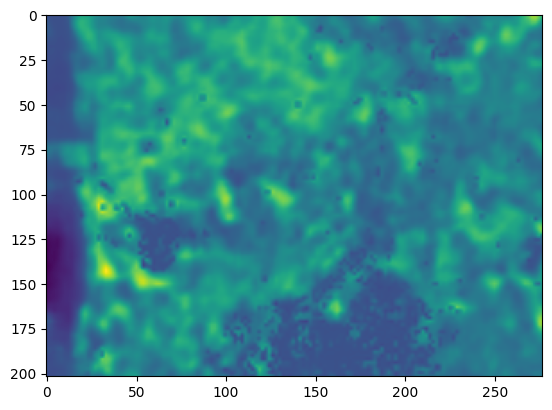

In [23]:
## SuperST 
def superst_gene(gene):
    index = gene_list.get_loc(gene)
    cropped_demask_image_t = process_image(demask_image_t[index], theta, size, left_margin, right_margin, top_margin, bottom_margin)
    cropped_demask_image_t = process_image(cropped_demask_image_t, 0, 1, 8, 23, 24, 0)
    return cropped_demask_image_t
superst_ERBB2 = superst_gene("ERBB2")
plt.imshow(superst_ERBB2)

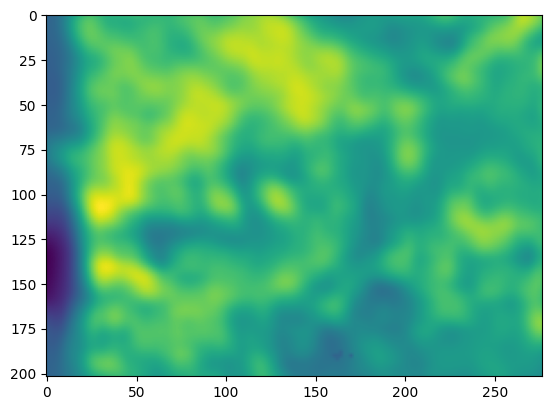

In [24]:
## SuperST (diffusion)
def superst_g_gene(gene):
    index = gene_list.get_loc(gene)
    cropped_demask_image_t_g = process_image(demask_image_t_g[index], theta, size, left_margin, right_margin, top_margin, bottom_margin)
    cropped_demask_image_t_g = process_image(cropped_demask_image_t_g, 0, 1, 8, 23, 24, 0)
    return cropped_demask_image_t_g
superst_g_ERBB2 = superst_g_gene("ERBB2")
plt.imshow(superst_g_ERBB2)

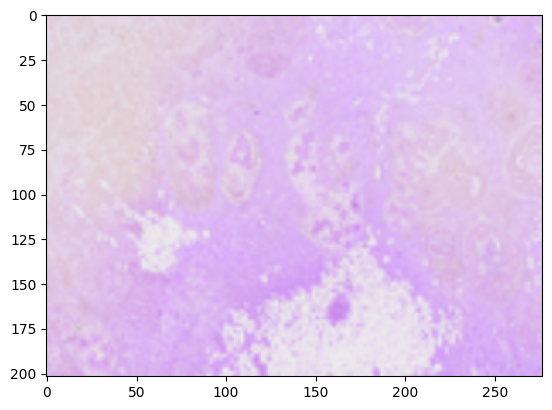

In [25]:
## H&E
def hne():
    cropped_tsimg1_ = process_image(tsimg1_, theta, size, left_margin, right_margin, top_margin, bottom_margin)
    cropped_tsimg1_ = process_image(cropped_tsimg1_, 0, 1, 8, 23, 24, 0)
    return cropped_tsimg1_
hne_img = hne()
plt.imshow(hne_img)

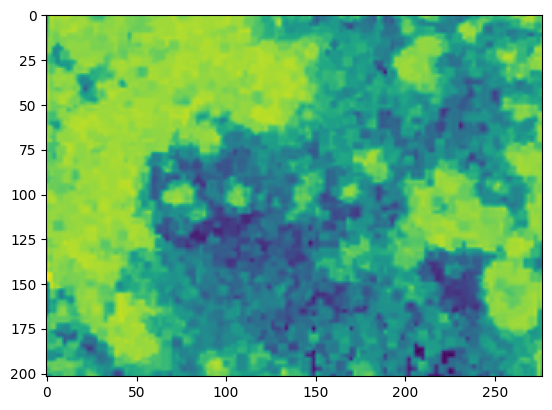

In [26]:
## conv
def conv_gene(gene):
    index = gene_list.get_loc(gene)
    cropped_conv = process_image(conv_spatial_images_[index], theta, size, left_margin, right_margin, top_margin, bottom_margin)
    cropped_conv = process_image(cropped_conv, 0, 1, 8, 23, 24, 0)
    return cropped_conv
conv_ERBB2 = conv_gene("ERBB2")
plt.imshow(conv_ERBB2)

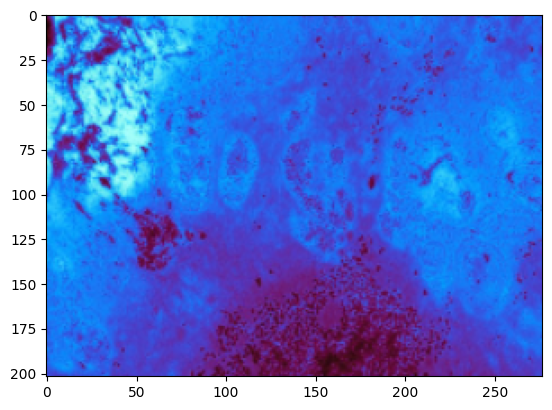

In [29]:
## XFuse
def xfuse_gene(gene):
    xfuse = cv2.imread(f"./_xfuse/_10x_xenium_visium/my-run/analyses/final/gene_maps/section4/{gene}_mean.jpg")
    xfuse = process_image(xfuse, 0, 202/386, 81, 84, 175, 180)
    target_shape = hne().shape
    xfuse = cv2.resize(xfuse, (target_shape[1], target_shape[0]))
    xfuse = process_image(xfuse, 0, 1, 30, 25, 9, 13)
    xfuse = cv2.resize(xfuse, (target_shape[1], target_shape[0]))
    return xfuse
xfuse_ERBB2 = xfuse_gene("ERBB2")
plt.imshow(xfuse_ERBB2)

/home/jeongbinpark/miniconda3/envs/SuperST/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


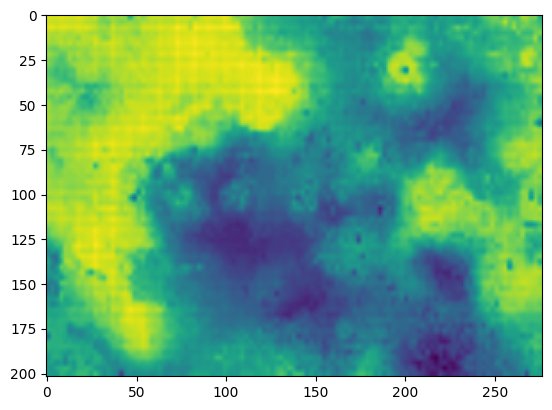

In [32]:
## TESLA
tesla = sc.read_h5ad("./_TESLA/xenium_visium/240916_TESLA_output.h5ad")
def tesla_gene(gene):
    index = gene_list.get_loc(gene)
    superst_space = process_image(demask_image_t[index], theta, size, left_margin, right_margin, top_margin, bottom_margin)
    tesla_img = tesla_to_superst_space(tesla, gene, superst_space)
    tesla_img = cv2.flip(tesla_img, 1)
    tesla_img = process_image(tesla_img, 180, 123/226, 27, 26, 17, 38)
    target_shape = hne().shape
    tesla_img = cv2.resize(tesla_img, (target_shape[1], target_shape[0]))
    return tesla_img
tesla_ERBB2 = tesla_gene("ERBB2")
plt.imshow(tesla_ERBB2)

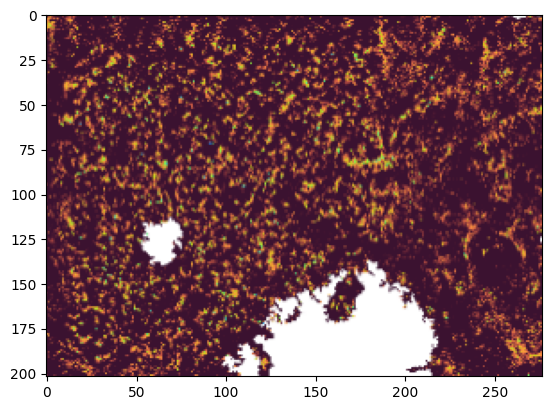

In [34]:
## iSTAR
def istar_gene(gene):
    istar = cv2.imread(f"../_istar/data/demo/cnts-super-plots/{gene}.png")
    istar = cv2.flip(istar, 1)
    istar = process_image(istar, 180, 202/824, 54, 59, 67, 48)
    target_shape = hne().shape
    istar = cv2.resize(istar, (target_shape[1], target_shape[0]))
    return istar
istar_ERBB2 = istar_gene("ERBB2")
plt.imshow(istar_ERBB2)

## Step 5. Benchmarking

In [ ]:
# Dictionary to hold SSIM scores
ssim_scores = { 'H&E': [], 'Conv': [], 'SuperST': [], 'XFuse': [], 'TESLA': [], 'iSTAR': [] }

# Calculate SSIM for each gene
for gene in gene_list:
    print(gene)
    xenium_img = xenium_gene(gene)

    try:
        # Calculate SSIM with each method and append to the respective list
        ssim_scores['XFuse'].append(ssim(xenium_img, rgb_to_grayscale(xfuse_gene(gene)), data_range=xenium_img.max() - xenium_img.min()))
        ssim_scores['SuperST'].append(ssim(xenium_img, superst_gene(gene), data_range=xenium_img.max() - xenium_img.min()))
        #ssim_scores['SuperST-G'].append(ssim(xenium_img, superst_g_gene(gene), data_range=xenium_img.max() - xenium_img.min()))
        ssim_scores['H&E'].append(ssim(xenium_img, rgb_to_grayscale(hne()), data_range=xenium_img.max() - xenium_img.min()))
        ssim_scores['Conv'].append(ssim(xenium_img, conv_gene(gene), data_range=xenium_img.max() - xenium_img.min()))
        ssim_scores['TESLA'].append(ssim(xenium_img, tesla_gene(gene), data_range=xenium_img.max() - xenium_img.min()))
        ssim_scores['iSTAR'].append(ssim(xenium_img, rgb_to_grayscale(istar_gene(gene)), data_range=xenium_img.max() - xenium_img.min()))
    except: 
        # XFuse skips some genes, leading to errors
        continue

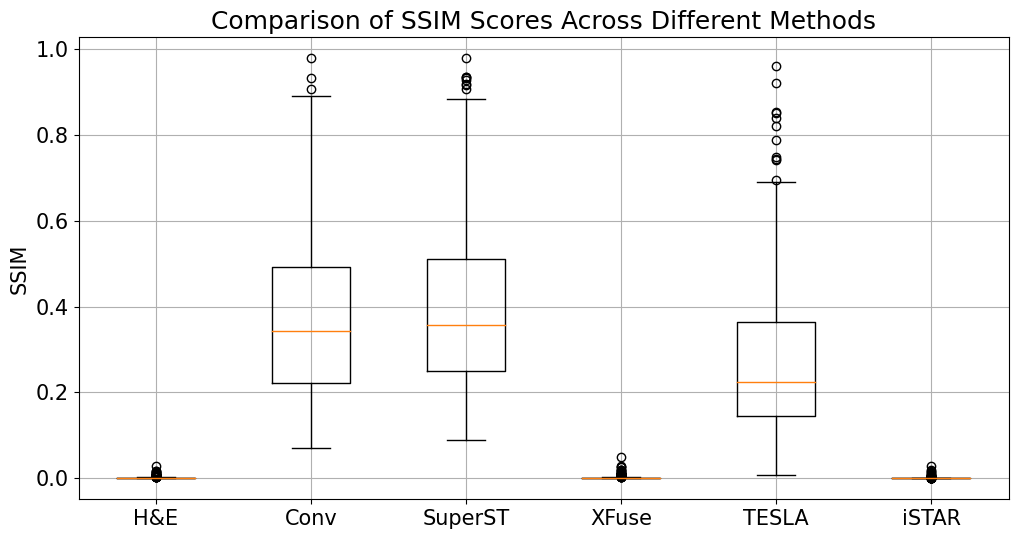

In [56]:
# Create a boxplot to compare SSIM scores
plt.rc('font', size = 15)
plt.figure(figsize=(12, 6))
plt.boxplot(ssim_scores.values(), labels=ssim_scores.keys())
plt.ylabel('SSIM')
plt.title('Comparison of SSIM Scores Across Different Methods')
plt.grid(True)
plt.show()

In [51]:
import json

# Save ssim_scores into a JSON file
with open('ssim_scores.json', 'w') as json_file:
    json.dump(ssim_scores, json_file)

print("SSIM scores have been saved to 'ssim_scores.json'")

SSIM scores have been saved to 'ssim_scores.json'
